# 🧪 Free Fall with Noise: Testing Huber Loss Function

## 📏 Huber Loss — Usage & Delta Selection Guide

### 1. Concept
Huber Loss combines the strengths of **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**:
- **For |r| ≤ δ** → behaves like **MSE** (quadratic penalty)  
  → strong gradient signal, faster convergence near the optimum.
- **For |r| > δ** → behaves like **MAE** (linear penalty)  
  → robustness to outliers, less sensitivity to extreme noise.

---

### 2. Why use it?
- **MSE**: Fast convergence, but sensitive to outliers.
- **MAE**: Robust to outliers, but slower convergence due to constant gradients.
- **Huber**: Quadratic for small errors, linear for large errors → balanced robustness and efficiency.

---

### 3. Choosing δ (delta)

#### Rule of thumb
- **Small δ** → more MAE-like: robust but slower to optimize.
- **Large δ** → more MSE-like: faster convergence, less robust to outliers.
- **Sweet spot**: δ ≈ scale of your *typical residuals*.

#### Data-driven approach
1. **Warm-up**: Train for a few epochs with a reasonable δ (e.g., 1.0 if data is standardized).
2. **Estimate residual scale**:
   - Robust: `s = median(|r|)` (Median Absolute Deviation)
   - Gaussian noise: `s = std(r)`
3. **Set δ**:
   - Start with δ ≈ 1.3–1.5 × s (classic robust regression choice).
   - Test a small sweep: {0.5×s, 1×s, 2×s}.
4. **Upper bound**:
   - Once δ ≥ 2–3 × s, Huber behaves almost exactly like MSE — no need to go higher.

---

### 4. Practical tips
- **If robustness is critical**:  
  - Use smaller δ or a δ-schedule (start large, reduce mid-training).
  - Increase early stopping patience and/or lower learning rate for small δ.
- **If speed is critical**:  
  - Use δ large enough to keep most residuals in the quadratic region.
- **Curriculum approach**:  
  - Begin with δ in the MSE-like range for fast convergence, then shrink δ to improve robustness.

---

### 5. Example (standardized data)
| δ       | Behavior                  | When to use                                  |
|---------|---------------------------|----------------------------------------------|
| 0.001   | Almost pure MAE            | Heavy-tailed noise, extreme outliers         |
| 0.01    | MAE-leaning hybrid         | Moderate outliers, slower but robust         |
| 0.1–1.0 | Balanced hybrid            | General-purpose, good cost–quality trade-off |
| ≥ 3×s   | Almost pure MSE            | Clean data, speed over robustness            |

---

**Summary:**  
Pick δ relative to your residual scale. Too small → slow; too large → loses robustness. For many standardized problems, δ in **[0.1, 1.0]** is a strong starting point.



## Creating the Data

In [1]:
import torch
from torch import nn

In [2]:
start = 0 
end = 10
n_samples = 100
steps = (end - start)/n_samples
t = torch.arange(start, end, steps).unsqueeze(dim=1)

# Constants
a = 4.9
b = 20
c = 300

X = torch.cat([t, t**2], dim = 1)
y = -a*t**2 + b*t + c

## Adding 5% Guassian Noise, Normalizing and Splitting the Data

In [3]:
import sys
sys.path.append('../utils')

from experiment_preparation import *

noise_level = 0.05 # 5% Guassian Noise 
y_noisy = adding_noise(noise_level, y)
normalized_data = normalization(X, y_noisy)
X_train, y_train, X_test, y_test = splitting_data(normalized_data.X_normalized, normalized_data.y_normalized)

## Training The Model

In [4]:
from model_architecture import LinearRegressionModel
from train_model import train_model, TrainingConfig

model = LinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.HuberLoss()

deltas = [0.001, 0.01, 0.1, 1]
losses_by_delta = {}
for delta in deltas:
    config = TrainingConfig(
        epochs=10000,
        window_size=200,
        patience=400,
        optimizer=optimizer,
        loss_fn=loss_fn,
        verbose=True,
        model_name=f"Best_Huber_loss_{delta}"
    )
    
    losses = train_model(model, X_train, y_train, X_test, y_test, config)
    losses_by_delta[delta] = losses


Epoch     0 | Train Loss: 1.019696 | Test Loss: 2.687536
Epoch   200 | Train Loss: 0.044243 | Test Loss: 0.761930
Epoch   400 | Train Loss: 0.031289 | Test Loss: 0.448742
Epoch   600 | Train Loss: 0.029240 | Test Loss: 0.363812
Epoch   800 | Train Loss: 0.027955 | Test Loss: 0.326391
Epoch  1000 | Train Loss: 0.026805 | Test Loss: 0.302375
Epoch  1200 | Train Loss: 0.025730 | Test Loss: 0.282824
Epoch  1400 | Train Loss: 0.024721 | Test Loss: 0.265254
Epoch  1600 | Train Loss: 0.023774 | Test Loss: 0.248987
Epoch  1800 | Train Loss: 0.022885 | Test Loss: 0.233762
Epoch  2000 | Train Loss: 0.022051 | Test Loss: 0.219470
Epoch  2200 | Train Loss: 0.021269 | Test Loss: 0.206065
Epoch  2400 | Train Loss: 0.020534 | Test Loss: 0.193490
Epoch  2600 | Train Loss: 0.019844 | Test Loss: 0.181692
Epoch  2800 | Train Loss: 0.019197 | Test Loss: 0.170623
Epoch  3000 | Train Loss: 0.018590 | Test Loss: 0.160239
Epoch  3200 | Train Loss: 0.018020 | Test Loss: 0.150496
Epoch  3400 | Train Loss: 0.017

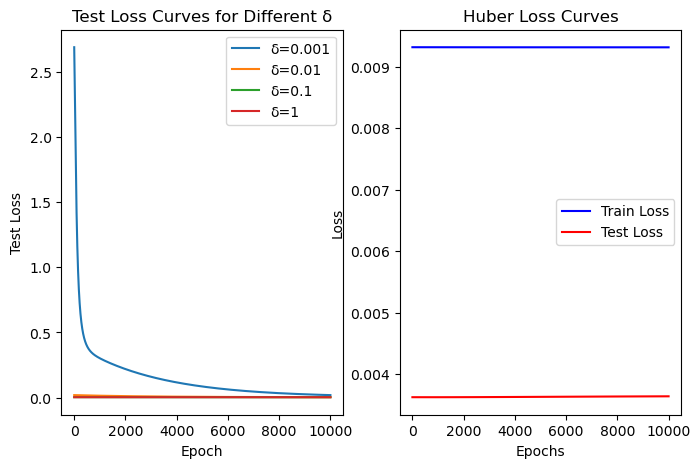

In [5]:
import matplotlib.pyplot as plt
from ploting_utils import plot_loss_curves

plt.figure(figsize=(8, 5))
plt.subplot(1,2,1)
for delta, res in losses_by_delta.items():
    plt.plot(range(res.epochs_run), res.test_losses[:res.epochs_run], label=f"δ={delta}")

plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.legend()
plt.title("Test Loss Curves for Different δ")
plt.subplot(1,2,2)
plot_loss_curves('Huber Loss', range(losses_by_delta[1][2]), losses_by_delta[1][0], losses_by_delta[1][1])



## Huber Loss: Balancing Robustness and Convergence

**Key idea:**  
Huber Loss blends the strengths of **Mean Absolute Error (MAE)** and **Mean Squared Error (MSE)**:
- For residuals `|r| ≤ δ`: behaves like **MSE** (quadratic penalty) → strong gradient signal, faster convergence when close to the target.
- For residuals `|r| > δ`: behaves like **MAE** (linear penalty) → robustness to outliers, less sensitivity to extreme noise.

---

### Experimental setup
- **Task:** Free-fall with 5% Gaussian noise.
- **Loss:** `torch.nn.HuberLoss(delta=δ)`
- **Deltas tested:** 0.001, 0.01, 0.1, 1.0
- **Training:** 10,000 epochs max, early stopping (window=200, patience=400), SGD (lr=0.01).

---

### Results summary

| δ       | Epoch stopped | Best Val Loss | Notes |
|---------|--------------:|--------------:|-------|
| 0.001   | 506           | 0.078802      | Almost pure MAE behavior → slow convergence, early stop, poor final loss. |
| 0.01    | 9999          | 0.008318      | Balanced but still slower than larger δ. |
| 0.1     | 9999          | 0.003727      | Best trade-off: strong curvature near residual scale, robust to noise. |
| 1.0     | 7371          | 0.003626      | Similar to δ=0.1, slightly earlier stop. |

---

### Interpretation
- **Small δ (0.001)**:  
  - Acts almost entirely like MAE.  
  - Robust to outliers but with constant‑magnitude gradients → slow optimization.  
  - Early stopping triggered before reaching competitive loss.

- **Large δ (0.1–1.0)**:  
  - Quadratic region covers most residuals → faster convergence and lower final loss.  
  - Still retains linear tails for robustness.

- **Intermediate δ (0.01)**:  
  - Balanced behavior but not optimal for this dataset/noise level.

---

### Conclusion
For this dataset and noise profile, **δ ≈ 0.1–1.0** offers the best cost–quality trade-off:
- **Quality:** Achieves lowest validation loss.
- **Cost:** Converges within reasonable epochs.
- **Robustness:** Maintains some protection against outliers.

---

### Practical note
If robustness to heavy-tailed noise is critical:
- Consider starting with a larger δ for faster initial convergence, then reducing δ mid‑training (curriculum approach) for instance:
```python
delta = 1.0  # start large for speed
for epoch in range(epochs):
    if epoch == 500:   # after initial convergence
        delta = 0.1    # tighten for robustness
    loss_fn = torch.nn.HuberLoss(delta=delta)
    train(model, loss_fn, optimizer)
```
- Alternatively, increase patience and adjust learning rate when using very small δ.



## Recovered Parameters

In [6]:
from recovered_parameters import recovered_parameters
for delta in deltas:
    recovered_parameters(f'Best_Huber_loss_{delta}', normalized_data.X_mean, normalized_data.X_std, normalized_data.y_mean, normalized_data.y_std)

Recovered Physical Parameters (Best_Huber_loss_0.001 Loss):
 a = 4.05, b = 13.00, c = 310.65

Recovered Physical Parameters (Best_Huber_loss_0.01 Loss):
 a = 4.73, b = 18.51, c = 303.10

Recovered Physical Parameters (Best_Huber_loss_0.1 Loss):
 a = 4.87, b = 19.64, c = 301.56

Recovered Physical Parameters (Best_Huber_loss_1 Loss):
 a = 4.87, b = 19.67, c = 301.52



## Visualizing the Predictions

Text(0.5, 1.0, 'Predicted Free Fall Model (Huber)')

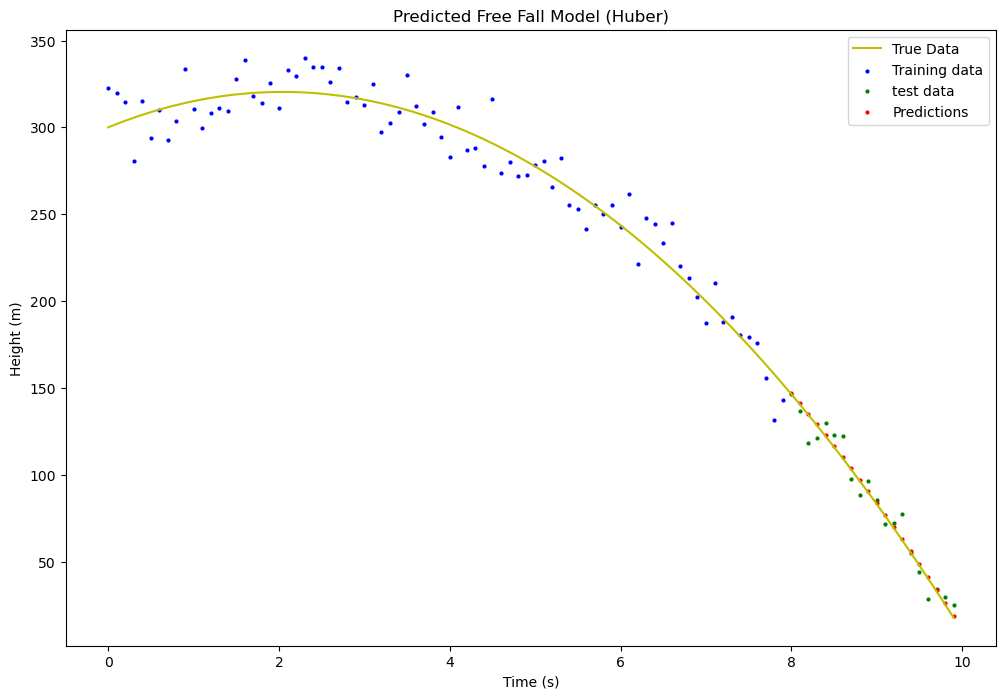

In [7]:
from ploting_utils import plot_predictions
from denormalizing import denormalize_parameters

X_train_denorm = X_train * normalized_data.X_std + normalized_data.X_mean
y_train_denorm = y_train * normalized_data.y_std + normalized_data.y_mean

X_test_denorm = X_test * normalized_data.X_std + normalized_data.X_mean
y_test_denorm = y_test * normalized_data.y_std + normalized_data.y_mean

state_dict = torch.load(f'../models/Best_Huber_loss_1.pth', weights_only=True)
model = LinearRegressionModel()
model.load_state_dict(state_dict)
weights = state_dict['linear_layer.weight']
bias = state_dict['linear_layer.bias']

model.eval()
with torch.no_grad():
    preds = model(X_test)

preds_denorm = preds * normalized_data.y_std + normalized_data.y_mean

plt.figure(figsize=(12,8))
plt.plot(t,y, c='y', label='True Data')
plot_predictions(X_train_denorm, y_train_denorm, X_test_denorm, y_test_denorm, preds_denorm)
plt.title('Predicted Free Fall Model (Huber)')

